In [9]:
import numpy as np
import pandas as pd
from scipy.signal import butter, lfilter, boxcar
from numpy import convolve
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from glob import glob
import os
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
# LeaveOneGroupOut交差検定
from sklearn.model_selection import LeaveOneGroupOut
# AUCスコア
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
 #############function to read data###########

def prepare_data_train(fname):
    """ read and prepare training data """
    # Read data
    data = pd.read_csv(fname)
    # events file
    events_fname = fname.replace('_data','_events')
    # read event file
    labels= pd.read_csv(events_fname)
    clean=data.drop(['id' ], axis=1)#remove id
    labels=labels.drop(['id' ], axis=1)#remove id
    return  clean,labels

def butterworth_filter(X,t,k,l):
    if t==0:
        freq=[k, l]
        b,a = butter(5,np.array(freq)/250.0,btype='bandpass')
        X = lfilter(b,a,X)
    elif t==1:
        b,a = butter(5,k/250.0,btype='lowpass')
        X = lfilter(b,a,X)
    elif t==2:
        b,a = butter(5,l/250.0,btype='highpass')
        X = lfilter(b,a,X)      
    return X

def prepare_data_test(fname):
    """ read and prepare test data """
    # Read data
    data = pd.read_csv(fname)
    return data

scaler= StandardScaler()
def data_preprocess_train(X):
    X_prep_normal = scaler.fit_transform(X)
    X_prep_low = np.zeros((np.shape(X_prep_normal)[0],10))
    for i in range(10):
        X_prep_low[:,i] = butterworth_filter(X[:,0],1,2-(i*0.2),3)
        X_prep_low[:,i] = scaler.fit_transform(X_prep_low[:,i])
    X_prep_low_pow = X_prep_low ** 2
    X_prep = np.concatenate((X_prep_low,X_prep_normal,X_prep_low_pow),axis=1)
    #do here your preprocessing
    return X_prep

def data_preprocess_test(X):
    X_prep_normal = scaler.fit_transform(X)
    X_prep_low = np.zeros((np.shape(X_prep_normal)[0],10))
    for i in range(10):
        X_prep_low[:,i] = butterworth_filter(X[:,0],1,2-(i*0.2),3)
        X_prep_low[:,i] = scaler.fit_transform(X_prep_low[:,i])
    X_prep_low_pow = X_prep_low ** 2
    X_prep = np.concatenate((X_prep_low,X_prep_normal,X_prep_low_pow),axis=1)
    return X_prep

In [3]:
# training subsample.if you want to downsample the training data
subsample = 100
#######columns name for labels#############
cols = ['HandStart','FirstDigitTouch',
        'BothStartLoadPhase','LiftOff',
        'Replace','BothReleased']

In [4]:
#######number of subjects###############
subjects = range(1,13)
ids_tot = []
pred_tot = []
y_tot = []
#series used for CV
series = range(1,9)
global_auc = []

In [49]:
###loop on subjects and 8 series for train data + 2 series for test data
for i, subject in enumerate(subjects):
    y_raw= []
    raw = []
    sequence = []
    auc_tot = []
    ################ READ DATA ################################################
    for ser in series:
        fname =  'input/train/subj%d_series%d_data.csv' % (subject,ser)
        data,labels=prepare_data_train(fname)
        raw.append(data)
        y_raw.append(labels)
        sequence.extend([ser]*len(data))

    X = pd.concat(raw)
    y = pd.concat(y_raw)
    #transform in numpy array
    #transform train data in numpy array
    X = np.asarray(X.astype(float))
    X = X
    y = np.asarray(y.astype(float))
    sequence = np.asarray(sequence)


    ################ Train classifiers ########################################
    cv = LeaveOneGroupOut()
    cv.get_n_splits(groups=sequence)
#     pred = np.empty((X.shape[0],6))
    
    clf1 = lda()
    clf2 = LogisticRegression()


    for train, test in cv.split(X, y, sequence):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train][:,0], y[test][:,0]
#         y_train, y_test = y_train[:,0], y_test[:,0]
        #apply preprocessing
    
        print('Train subject %d, class %s' % (subject, cols[0]))
        clf1.fit(X_train[::subsample,:],y_train[::subsample])
        clf2.fit(X_train[::subsample,:],y_train[::subsample])
        pred1 = clf1.predict_proba(X_test)
        pred2 = clf2.predict_proba(X_test)
        pred = (0.675*pred1+0.325*pred2)
#         clf.fit(X_train,y_train)
#         pred = clf.predict(X_test)

        y_binary = to_categorical(y_test)
        auc = roc_auc_score(y_binary,pred)    
        auc_tot.append(auc)
        print("subject", i + 1)
        print(auc)

    auc_tot = np.asarray(auc_tot)
    print(auc_tot)
    print('Mean AUC', np.mean(auc_tot))
    global_auc.append(np.mean(auc_tot))
# plt.figure(figsize=(4,3))
# plt.plot(auc_tot)
# plt.xlabel('Subject')
# plt.ylabel('AUC')
# plt.title('CV auc for each subject')
# plt.savefig('cross_val_auc_subject.png' ,bbox_inches='tight')



Train subject 1, class HandStart
subject 1
0.637640118707
Train subject 1, class HandStart
subject 1
0.807648112495
Train subject 1, class HandStart
subject 1
0.793960251414
Train subject 1, class HandStart
subject 1
0.692628925891
Train subject 1, class HandStart
subject 1
0.800221315639
Train subject 1, class HandStart
subject 1
0.795057628369
Train subject 1, class HandStart
subject 1
0.711596961445
Train subject 1, class HandStart
subject 1
0.736444494061
[ 0.63764012  0.80764811  0.79396025  0.69262893  0.80022132  0.79505763
  0.71159696  0.73644449]
Mean AUC 0.746899726003
Train subject 2, class HandStart
subject 2
0.68438173733
Train subject 2, class HandStart
subject 2
0.410085481054
Train subject 2, class HandStart
subject 2
0.717556393549
Train subject 2, class HandStart
subject 2
0.801133586197
Train subject 2, class HandStart
subject 2
0.750579332308
Train subject 2, class HandStart
subject 2
0.764048429898
Train subject 2, class HandStart
subject 2
0.76901198343
Train sub

In [62]:
global_auc
sum(global_auc) / float(len(global_auc))

0.75108898889137621

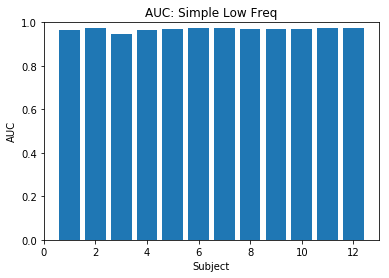

In [17]:
fig, ax = plt.subplots()
x = range(1, len(global_auc)+1)
plt.bar(x, global_auc)
plt.ylim(0.0, 1.0)
plt.xlabel('Subject')
plt.ylabel('AUC')
plt.title('AUC: Simple Low Freq')
plt.show()
# plt.savefig('cross_val_auc_subject.png' ,bbox_inches='tight')

In [6]:
#######number of subjects###############
subjects = range(1,13)
ids_tot = []
pred_tot = []
y_tot = []
#series used for CV
series = range(1,9)
global_acc = []

In [11]:
###loop on subjects and 8 series for train data + 2 series for test data
for i, subject in enumerate(subjects):
    y_raw= []
    raw = []
    sequence = []
    acc_tot = []
    ################ READ DATA ################################################
    for ser in series:
        fname =  'input/train/subj%d_series%d_data.csv' % (subject,ser)
        data,labels=prepare_data_train(fname)
        raw.append(data)
        y_raw.append(labels)
        sequence.extend([ser]*len(data))

    X = pd.concat(raw)
    y = pd.concat(y_raw)
    #transform in numpy array
    #transform train data in numpy array
    X = np.asarray(X.astype(float))
    y = np.asarray(y.astype(float))
    y_handstart = y[:,0]
    sequence = np.asarray(sequence)


    ################ Train classifiers ########################################
    cv = LeaveOneGroupOut()
    cv.get_n_splits(groups=sequence)
#     pred = np.empty((X.shape[0],6))
    
    clf1 = lda()
    clf2 = LogisticRegression()
    
    


    for train, test in cv.split(X, y, sequence):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train][:,0], y[test][:,0]
        #apply preprocessing
    
        print('Train subject %d, class %s' % (subject, cols[0]))
        clf1.fit(X_train[::subsample,:],y_train[::subsample])
        clf2.fit(X_train[::subsample,:],y_train[::subsample])
        pred1 = clf1.predict(X_test)
        pred2 = clf2.predict(X_test)
        pred = pred1 * pred2
#         pred = (0.675*pred1+0.325*pred2)
#         clf.fit(X_train,y_train)
#         pred = clf.predict(X_test)

#         y_binary = to_categorical(y_test)
        acc = accuracy_score(y_test,pred)    
        acc_tot.append(acc)
        print("subject", i + 1)
        print(acc)

    acc_tot = np.asarray(acc_tot)
    print(acc_tot)
    print('Mean ACC', np.mean(acc_tot))
    global_acc.append(np.mean(acc_tot))
# plt.figure(figsize=(4,3))
# plt.plot(auc_tot)
# plt.xlabel('Subject')
# plt.ylabel('AUC')
# plt.title('CV auc for each subject')
# plt.savefig('cross_val_auc_subject.png' ,bbox_inches='tight')



Train subject 1, class HandStart
subject 1
0.935855593493
Train subject 1, class HandStart
subject 1
0.980526118388
Train subject 1, class HandStart
subject 1
0.98070896174
Train subject 1, class HandStart
subject 1
0.956194081211
Train subject 1, class HandStart
subject 1
0.980046903781
Train subject 1, class HandStart
subject 1
0.979575235424
Train subject 1, class HandStart
subject 1
0.95746104499
Train subject 1, class HandStart
subject 1
0.956533967426
[ 0.93585559  0.98052612  0.98070896  0.95619408  0.9800469   0.97957524
  0.95746104  0.95653397]
Mean AUC 0.965862738306
Train subject 2, class HandStart
subject 2
0.985610229071
Train subject 2, class HandStart
subject 2
0.984549293812
Train subject 2, class HandStart
subject 2
0.966611018364
Train subject 2, class HandStart
subject 2
0.98165860043
Train subject 2, class HandStart
subject 2
0.966369265465
Train subject 2, class HandStart
subject 2
0.979633598743
Train subject 2, class HandStart
subject 2
0.966194942498
Train subj

In [13]:
global_acc
sum(global_acc) / float(len(global_acc))

0.96897412744472067

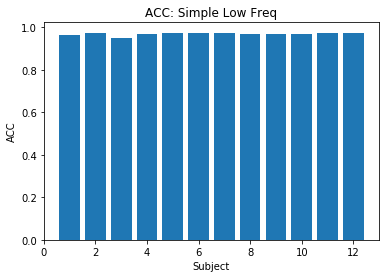

In [15]:
fig, ax = plt.subplots()
x = range(1, len(global_acc)+1)
plt.bar(x, global_acc)
plt.xlabel('Subject')
plt.ylabel('ACC')
plt.title('ACC: Simple Low Freq')
plt.show()
# plt.savefig('cross_val_auc_subject.png' ,bbox_inches='tight')